In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import bemcs
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Input file and mesh geometry
Provide an input file with mesh endpoints and boundary condition labels

In [37]:
fileinput = "maduo_flatmesh.csv"

datain = pd.read_csv(fileinput)

x1 = datain["x1"].values
x2 = datain["x2"].values
y1 = datain["z1"].values
y2 = datain["z2"].values
BCtype = datain["BC_type"].values
BCval = datain["value"].values

# Elastic parameters and lithostatic effects
mu = 30  # in GPa
rho = 2.600  # normally in kg/m^3 but dividde by 1e3 so that rho*g*y is in MPa (note y is in km)
ydatum = 4.4  # provide a datum in km
sigmay_0 = 1  # yield stress at the free surface

Everything below this point is handled by various functions within `bemcs` and this notebook provides a template for applying it in antiplane geometry. It is unlikely that anything needs to be changed by the user until they get to the display and visualization section

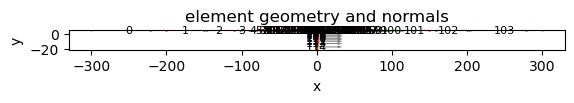

Number of open nodes = 3
: [array([0]), array([344]), array([311])]
Number of 2-overlap nodes = 112
: [array([ 3, -2]), array([ 6, -5]), array([ 9, -8]), array([ 12, -11]), array([ 15, -14]), array([ 18, -17]), array([ 21, -20]), array([ 24, -23]), array([ 27, -26]), array([ 30, -29]), array([ 33, -32]), array([ 36, -35]), array([ 39, -38]), array([ 42, -41]), array([ 45, -44]), array([ 48, -47]), array([ 51, -50]), array([ 54, -53]), array([ 57, -56]), array([ 60, -59]), array([ 63, -62]), array([ 66, -65]), array([ 69, -68]), array([ 72, -71]), array([ 75, -74]), array([ 78, -77]), array([ 81, -80]), array([ 84, -83]), array([ 87, -86]), array([ 90, -89]), array([ 93, -92]), array([ 96, -95]), array([ 99, -98]), array([ 102, -101]), array([ 105, -104]), array([ 108, -107]), array([ 111, -110]), array([ 114, -113]), array([ 117, -116]), array([ 120, -119]), array([ 123, -122]), array([ 126, -125]), array([ 129, -128]), array([ 132, -131]), array([ 135, -134]), array([ 138, -137]), arr

In [38]:
# construct mesh
els = bemcs.initialize_els()
stride = 3

els.x1 = x1 / 1e3
els.y1 = y1 / 1e3
els.x2 = x2 / 1e3
els.y2 = y2 / 1e3

bemcs.standardize_els_geometry(els, reorder=False)

n_els = len(els.x1)
bemcs.plot_els_geometry(els)

index_open, index_overlap, index_triple = bemcs.label_nodes(els)
N_c = n_els  # central node equations
N_o = len(index_open)  # open node equations
N_i = 2 * len(index_overlap)  # overlapping node equations
N_t = 3 * len(index_triple)  # triple junction equations

Nequations = N_c + N_o + N_i + N_t
Nunknowns = stride * n_els
# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = BCval.reshape(-1, 1)  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

matrix_system_o, matrix_system_i, matrix_system_t = (
    bemcs.construct_smoothoperator_antiplane(
        els, index_open, index_overlap, index_triple
    )
)
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient_antiplane(
    els, flag="node"
)
kernels = bemcs.get_displacement_stress_kernel_slip_antiplane(
    els.x_centers, els.y_centers, els, mu
)
t_kernels = bemcs.get_traction_kernels_antiplane(els, kernels)

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))

# populate matrix_system for central nodes (check for bc_label)
for i in range(n_els):
    if BCtype[i] == "s":
        matrix_system_c[i, :] = slip_mat[stride * i + 1, :]
    elif BCtype[i] == "t":
        matrix_system_c[i, :] = t_kernels[i, :]
    else:
        ValueError("boundary condition label not recognized")

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

# Solve linear system of equations and get solution coeffcients (on the boundary)

In [39]:
# Solve for quadratic node coefficients
quadcoefs = np.linalg.inv(matrix_system) @ BCvector

# Visualization of results
Below I show how one can plot a number of useful quantities
- Extract the slip distribution and plot it
- Internal displacement and stress components
- Closeness to failure (assuming depth-dependent yield condition)

## Fault slip distribution

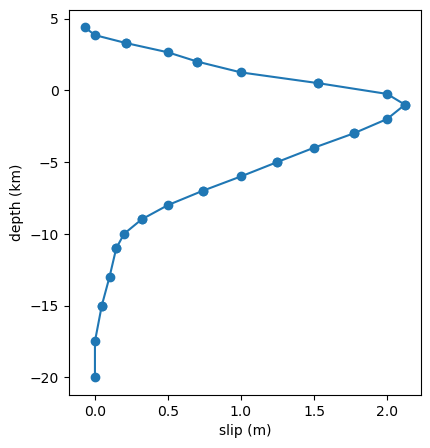

In [40]:
# extract slip at fault-slip nodes
index = BCtype == "s"
nfaultnodes = np.sum(index)

yf = np.zeros(3 * nfaultnodes)
slipnodes = np.zeros((3 * nfaultnodes, 1))
yf[0::3] = els.y1[index]
yf[1::3] = els.y_centers[index]
yf[2::3] = els.y2[index]

slipnodes[0::3] = (slip_mat @ quadcoefs)[0::3][index]
slipnodes[1::3] = (slip_mat @ quadcoefs)[1::3][index]
slipnodes[2::3] = (slip_mat @ quadcoefs)[2::3][index]

# plot slip distribution on the fault as a function of depth
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(slipnodes, yf, "o-")
plt.xlabel("slip (m)")
plt.ylabel("depth (km)")
plt.show()

## Internal displacement and stress field

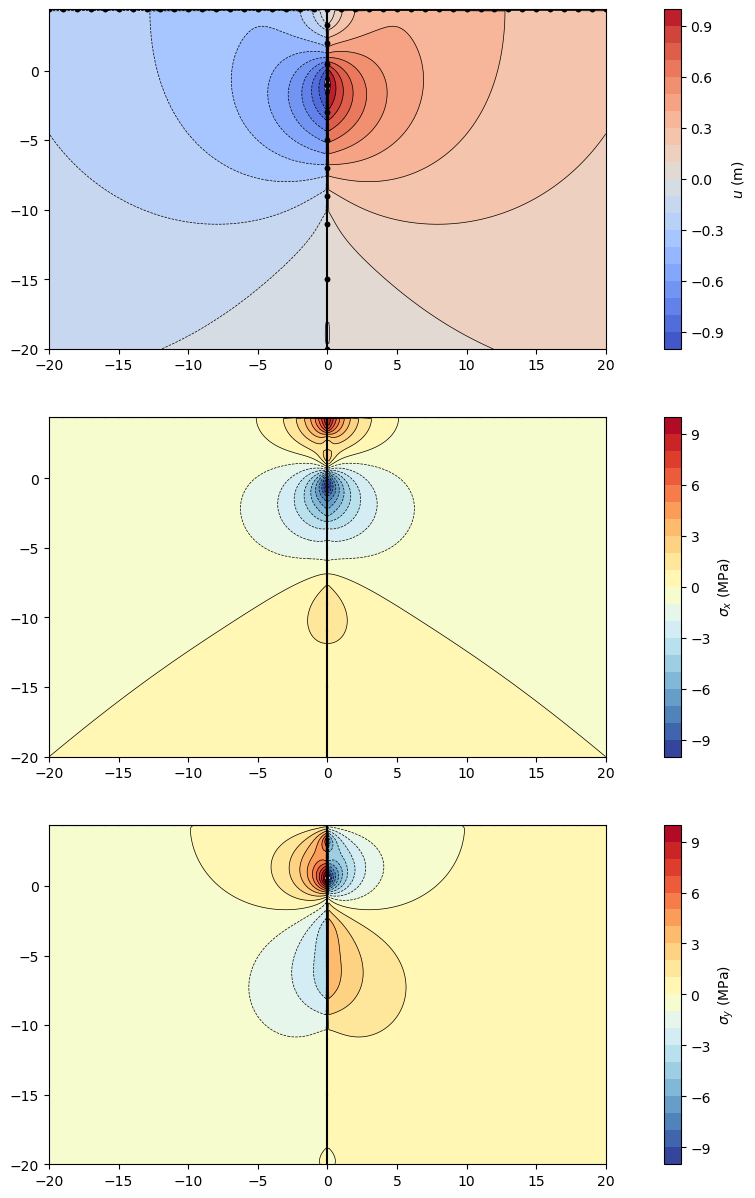

In [41]:
xlimits = [-20, 20]
nx_obs = 200
ny_obs = nx_obs
x_obs = np.linspace(-20, 20, nx_obs)
y_obs = np.linspace(-20, 4.41, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xo = x_obs.flatten().reshape(-1, 1)
yo = y_obs.flatten().reshape(-1, 1)

K_sx, K_sy, K_u = bemcs.get_displacement_stress_kernel_slip_antiplane(xo, yo, els, mu)

# compute displacement and stress components
u = K_u @ quadcoefs
sx = K_sx @ quadcoefs
sy = K_sy @ quadcoefs

plt.figure(figsize=(15, 15))
plt.subplot(3, 1, 1)
toplot = u.reshape(ny_obs, nx_obs)
maxval = 1
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.colorbar(label="$u$ (m)")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.xlim(xlimits)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 1, 2)
toplot = sx.reshape(ny_obs, nx_obs)
maxval = 10
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="RdYlBu_r",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.colorbar(label="$\sigma_x$ (MPa)")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.xlim(xlimits)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 1, 3)
toplot = sy.reshape(ny_obs, nx_obs)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="RdYlBu_r",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
plt.colorbar(label="$\sigma_y$ (MPa)")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.xlim(xlimits)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

## Closeness to failure

We can define closeness to failure as $$CF(x,z) = \frac{|\sigma(x,z)|}{\sigma_f(z)}$$ 
where $|\sigma(x,z)| = \sqrt{\sigma_x^2 + \sigma_y^2}$ is the deviatoric stress level at any point $(x,z)$ within the medium while $\sigma_f = f_0\rho g |z-z_0|$ is a depth-dependent or normal-stress dependent frictional yield criterion. We visualize this quantity in two ways:
- plot in log-scale
- plot in linear scale

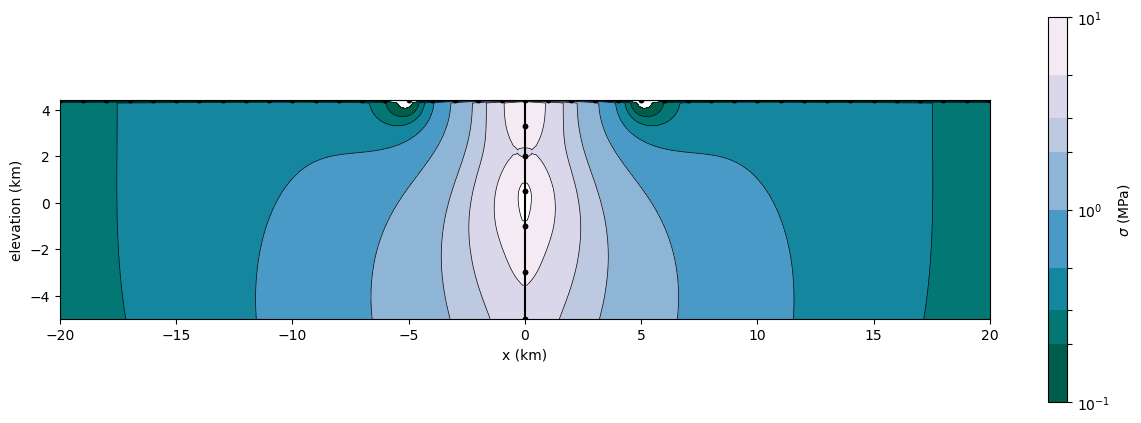

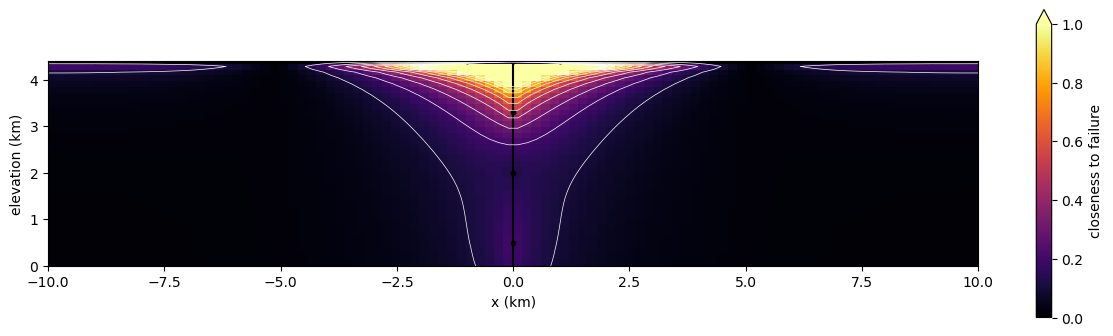

In [42]:
# logarithmic scale for closeness to failure
plt.figure(figsize=(15, 5))
frictioncoef = 0.6

toplot = (np.sqrt(sx**2 + sy**2)).reshape(ny_obs, nx_obs)
maxval = 10
minval = 0.1
levels = np.array([0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10])
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="PuBuGn_r",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    norm=LogNorm(),
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.colorbar(label="$\sigma$ (MPa)")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.xlim(xlimits)
plt.ylim([-5, 4.4])
plt.xlabel("x (km)")
plt.ylabel("elevation (km)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

# linear scale plot
toplot = (
    np.sqrt(sx**2 + sy**2)
    / (frictioncoef * (sigmay_0 + rho * 9.8 * np.abs(yo - ydatum)))
).reshape(ny_obs, nx_obs)
plt.figure(figsize=(15, 4))
maxval = 1.0
minval = 0
levels = np.linspace(minval, maxval, 11)
# plt.contourf(
#     xo.reshape(ny_obs, nx_obs),
#     yo.reshape(ny_obs, nx_obs),
#     toplot,
#     cmap="inferno",
#     vmin=minval,
#     vmax=maxval,
#     levels=levels,
# )
plt.pcolor(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="inferno",
    vmin=minval,
    vmax=maxval,
)
plt.colorbar(label="closeness to failure", extend="max")
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="white",
    levels=levels,
    linewidths=0.5,
)
plt.xlim([-10, 10])
plt.ylim([0, 4.4])
plt.xlabel("x (km)")
plt.ylabel("elevation (km)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

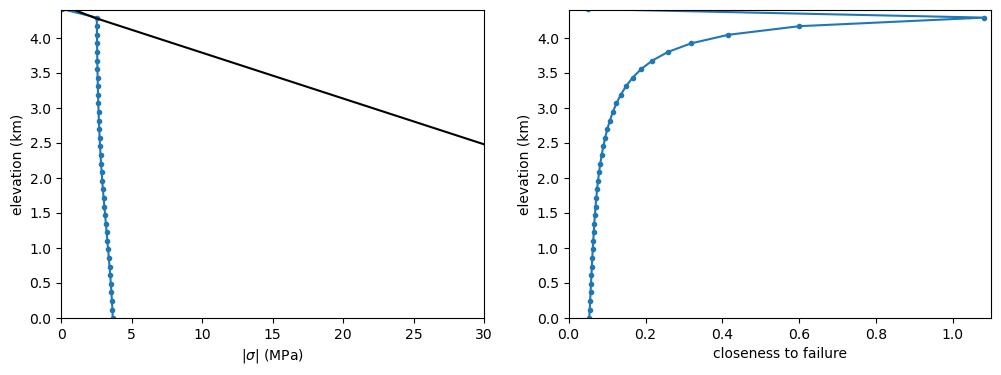

In [43]:
index = (xo > 1.8) & (xo < 2)
toplot = np.sqrt(sx**2 + sy**2)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(toplot[index], yo[index], ".-")
plt.plot(
    frictioncoef * (sigmay_0 + rho * 9.8 * np.abs(yo[index] - ydatum)), yo[index], "k-"
)
plt.ylim([0, 4.4])
plt.xlim([0, 30])
plt.xlabel("$|\sigma|$ (MPa)")
plt.ylabel("elevation (km)")

plt.subplot(1, 2, 2)
plt.plot(
    toplot[index]
    / (frictioncoef * (sigmay_0 + rho * 9.8 * np.abs(yo[index] - ydatum))),
    yo[index],
    ".-",
)
plt.ylim([0, 4.4])
plt.xlim([0, 1.1])
plt.xlabel("closeness to failure")
plt.ylabel("elevation (km)")
plt.show()